In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/test-production/merged_ana_tree_hd.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/test-production/parquet',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 10/10
Reading geant files... 10/10
Reading reco_tracks files... 10/10
Reading reco_showers files... 10/10
Reading pfp files... 10/10


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged = 0

# for i,n in enumerate(nu):
#     df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
#     df = df.collect()
#     if i == 0:
#         merged = df
#     else:
#         merged = pl.concat([merged,df])

In [4]:
df:pl.DataFrame
df = 0
for i,n in enumerate(nu):
    dfg = geant[i]#.head(1000000)
    dfnu = n.filter(pl.col('ccnc_truth')==0).filter(pl.col('nuPDG_truth').abs()==14)
    dfg = dfg.filter(pl.col('Mother_geant')==0)
    gcc = (
        dfg.join(dfnu, left_on=['subrun','event'], right_on=['subrun', 'event'], how='inner')
    ).collect()
    if i == 0:
      df = gcc  
    else:
        df = pl.concat([df,gcc])
        # if i == 1:
        #    break


# df.groupby(['subrun']).agg(pl.col('event').unique().count()).sort(['subrun']).sum()

In [5]:
df.groupby(['subrun']).agg(pl.col('event').unique().count()).sort(['subrun']).sum()

subrun,event
i32,u32
12464643,25168


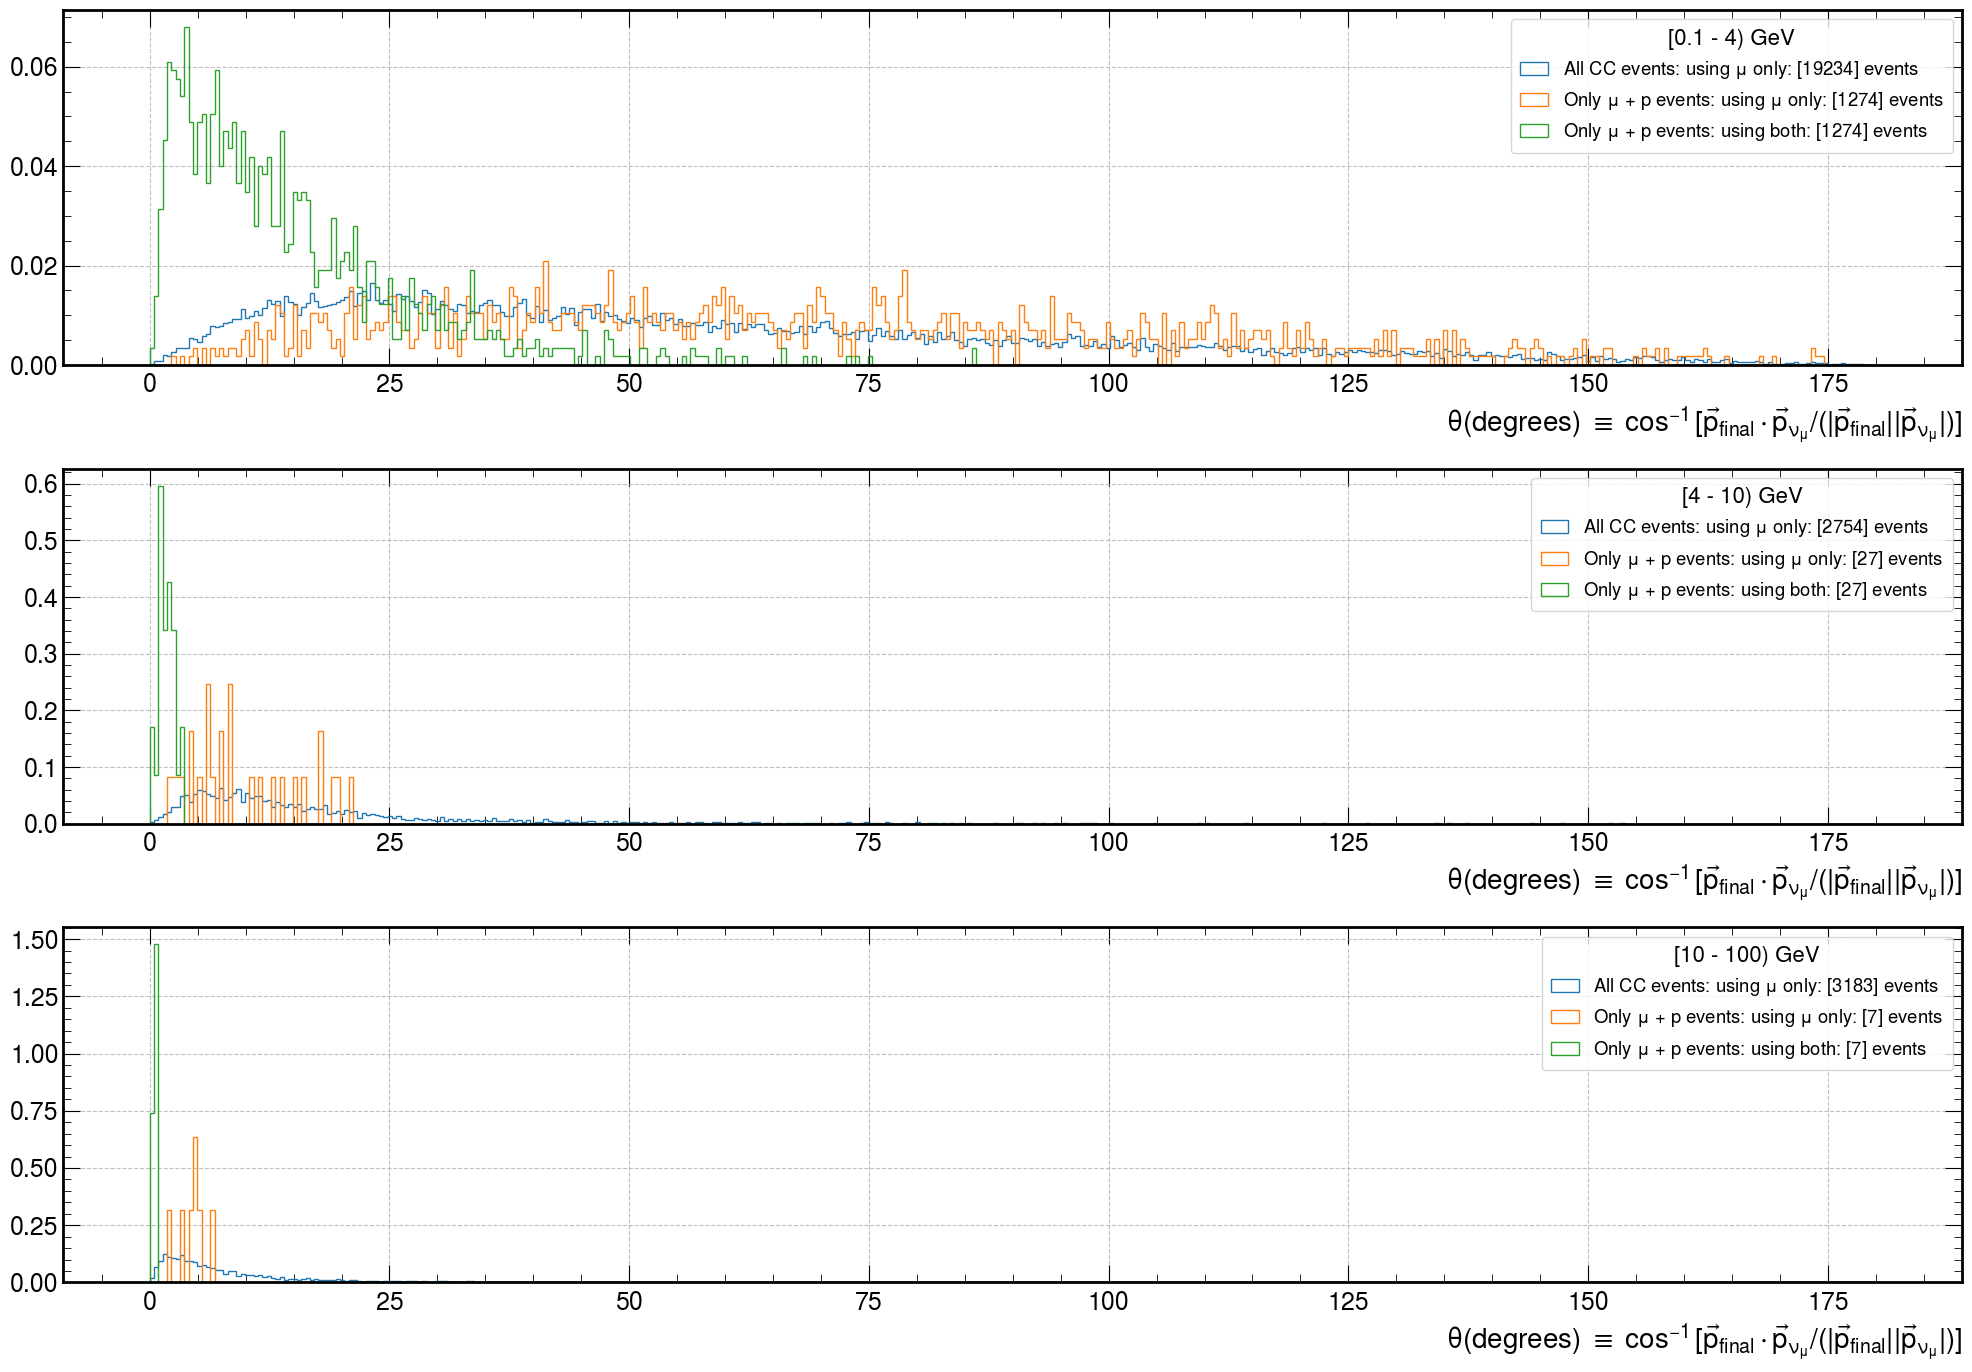

In [8]:
def create_intervals():
    global Ebins
    intervals = []
    for i, e in enumerate(Ebins[:-1]):
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
    return intervals
def plot_by_energy(bins, df:pl.DataFrame, variables, labels, fig=None, columns = 3, show_entries=False, **kwargs):

    global Ebins
    if 'figsize' in kwargs:
        figsize=kwargs.pop('figsize')
    else:
        figsize=(14,10)

    nplots = len(Ebins) - 1
    rows = nplots//columns
    last_empty= False
    if nplots%columns != 0:
        last_empty = True
        rows+=1

    qc = [] 
    intervals = []
    entries = []
    for i, e in enumerate(Ebins[:-1]):
        qt = df.filter(
            (pl.col('enu_truth') >= e) & (pl.col('enu_truth') < Ebins[i+1])
        ).with_columns(
            counts = pl.col('enu_truth').count()
        )
        qc.append(qt)
        entries.append(qt.head(1)['counts'].to_numpy())
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
        
    axes=0 
    if fig is None:
        fig, axes = plt.subplots(rows,columns,figsize=figsize)
    else:
        axes = fig.get_axes()

    vbin_centers = [0 for _ in axes]
    vbin_heights = [0 for _ in axes]
    for i, (inter,ax) in enumerate(zip(intervals,axes)):
        ax:plt.Axes
        for var,label in zip(variables,labels):
            if show_entries: label = label + f': {entries[i]} events'
            bin_heights, bin_borders, _ = ax.hist(qc[i][var], bins=bins, histtype='step', label=label, density=True);
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
            vbin_centers[i] = bin_centers
            vbin_heights[i] = bin_heights
            ax.set_xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$', fontsize=20)
            ax.tick_params(labelsize=18)
            ax.legend(frameon=True, title=intervals[i])
    return fig, vbin_centers, vbin_heights

def get_angle(str_g, str_nu, geant_type='geant'):
    variables = ['x','y','z']
    mom_geant = [str_g + v + '_' + geant_type for v in variables]
    mom_nu = [str_nu+v + '_truth'for v in variables]
    r = pl.col(mom_geant[0])*pl.col(mom_nu[0])
    for mg, mn in zip(mom_geant[1:], mom_nu[1:]):
        r += pl.col(mg)*pl.col(mn)

    # return r
    return (r/pl.col(str_g+'_'+geant_type).abs()).arccos()*180/np.pi
        
q = (
    df.filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).select(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        pl.col('enu_truth'),
        angle_diff = get_angle('P','nu_dcos'),
    )
)

q2 = df.groupby(['subrun', 'event']).agg(
    pl.col('nu_dcosx_truth').first().alias('nu_dcostx_truth'),
    pl.col('nu_dcosy_truth').first().alias('nu_dcosty_truth'),
    pl.col('nu_dcosz_truth').first().alias('nu_dcostz_truth'),
    pl.col('enu_truth').first(),
    pl.col('Px_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psx_geant'),
    pl.col('Py_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psy_geant'),
    pl.col('Pz_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psz_geant'),
    pl.col('Px_geant').sum().alias('Ptx_geant'),
    pl.col('Py_geant').sum().alias('Pty_geant'),
    pl.col('Pz_geant').sum().alias('Ptz_geant'),
    pl.col('^P[a-z]_geant$'),
    pl.col('pdg_geant'),
    pl.col('pdg_geant').filter((pl.col('pdg_geant').abs()==13) | (pl.col('pdg_geant').abs()==2212)).alias('pdg_geant_group'),
    
).with_columns(
    pl.col('pdg_geant_group').list.lengths().alias('len_select'),
    pl.col('pdg_geant').list.lengths().alias('len'),
    Pt_geant = (pl.col('Ptx_geant').pow(2) + pl.col('Pty_geant').pow(2) + pl.col('Ptz_geant').pow(2)).sqrt(),
    Ps_geant = (pl.col('Psx_geant').pow(2) + pl.col('Psy_geant').pow(2) + pl.col('Psz_geant').pow(2)).sqrt(),
).filter(( pl.col('len_select')==2 ) & (pl.col('len') == 2))


q_mu_proton = (
    q2.select(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        # pl.all(),
        pl.col('enu_truth'),
        angle_diff_s = get_angle('Ps','nu_dcost'),
        angle_diff_t = get_angle('Pt','nu_dcost'),
    )
)
# plt.hist(q['angle_diff'], bins=np.linspace(-20,180,200), histtype='step', label=r'All CC events: using $\mu$ only', density=True);
bins = np.linspace(0,180,400)
# bins = np.linspace(0,20,100)
Ebins = [0.1,4,10,100]
fig, _, _ = plot_by_energy(bins=bins,df=q,variables=['angle_diff'],labels=[r'All CC events: using $\mu$ only'], columns=1, show_entries=True, figsize=(20,14))
fig, _, _ = plot_by_energy(bins=bins,df=q_mu_proton,variables=['angle_diff_s'],labels=[r'Only $\mu$ + p events: using $\mu$ only'], fig = fig, columns=1, show_entries=True, figsize=(20,14))
fig, x, y = plot_by_energy(bins=bins,df=q_mu_proton,variables=['angle_diff_t'],labels=[r'Only $\mu$ + p events: using both'], fig = fig, columns=1, show_entries=True, figsize=(20,14))

# fig.get_axes()[1].hist(q_mu_proton['angle_diff_s'], bins=np.linspace(-20,180,200), histtype='step', label=r'Only $\mu$ + p events: using $\mu$ only', density=True);
# plt.hist(q_mu_proton['angle_diff_t'], bins=np.linspace(-20,180,200), histtype='step', label='test', density=True);
# plt.xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$')
# plt.legend()


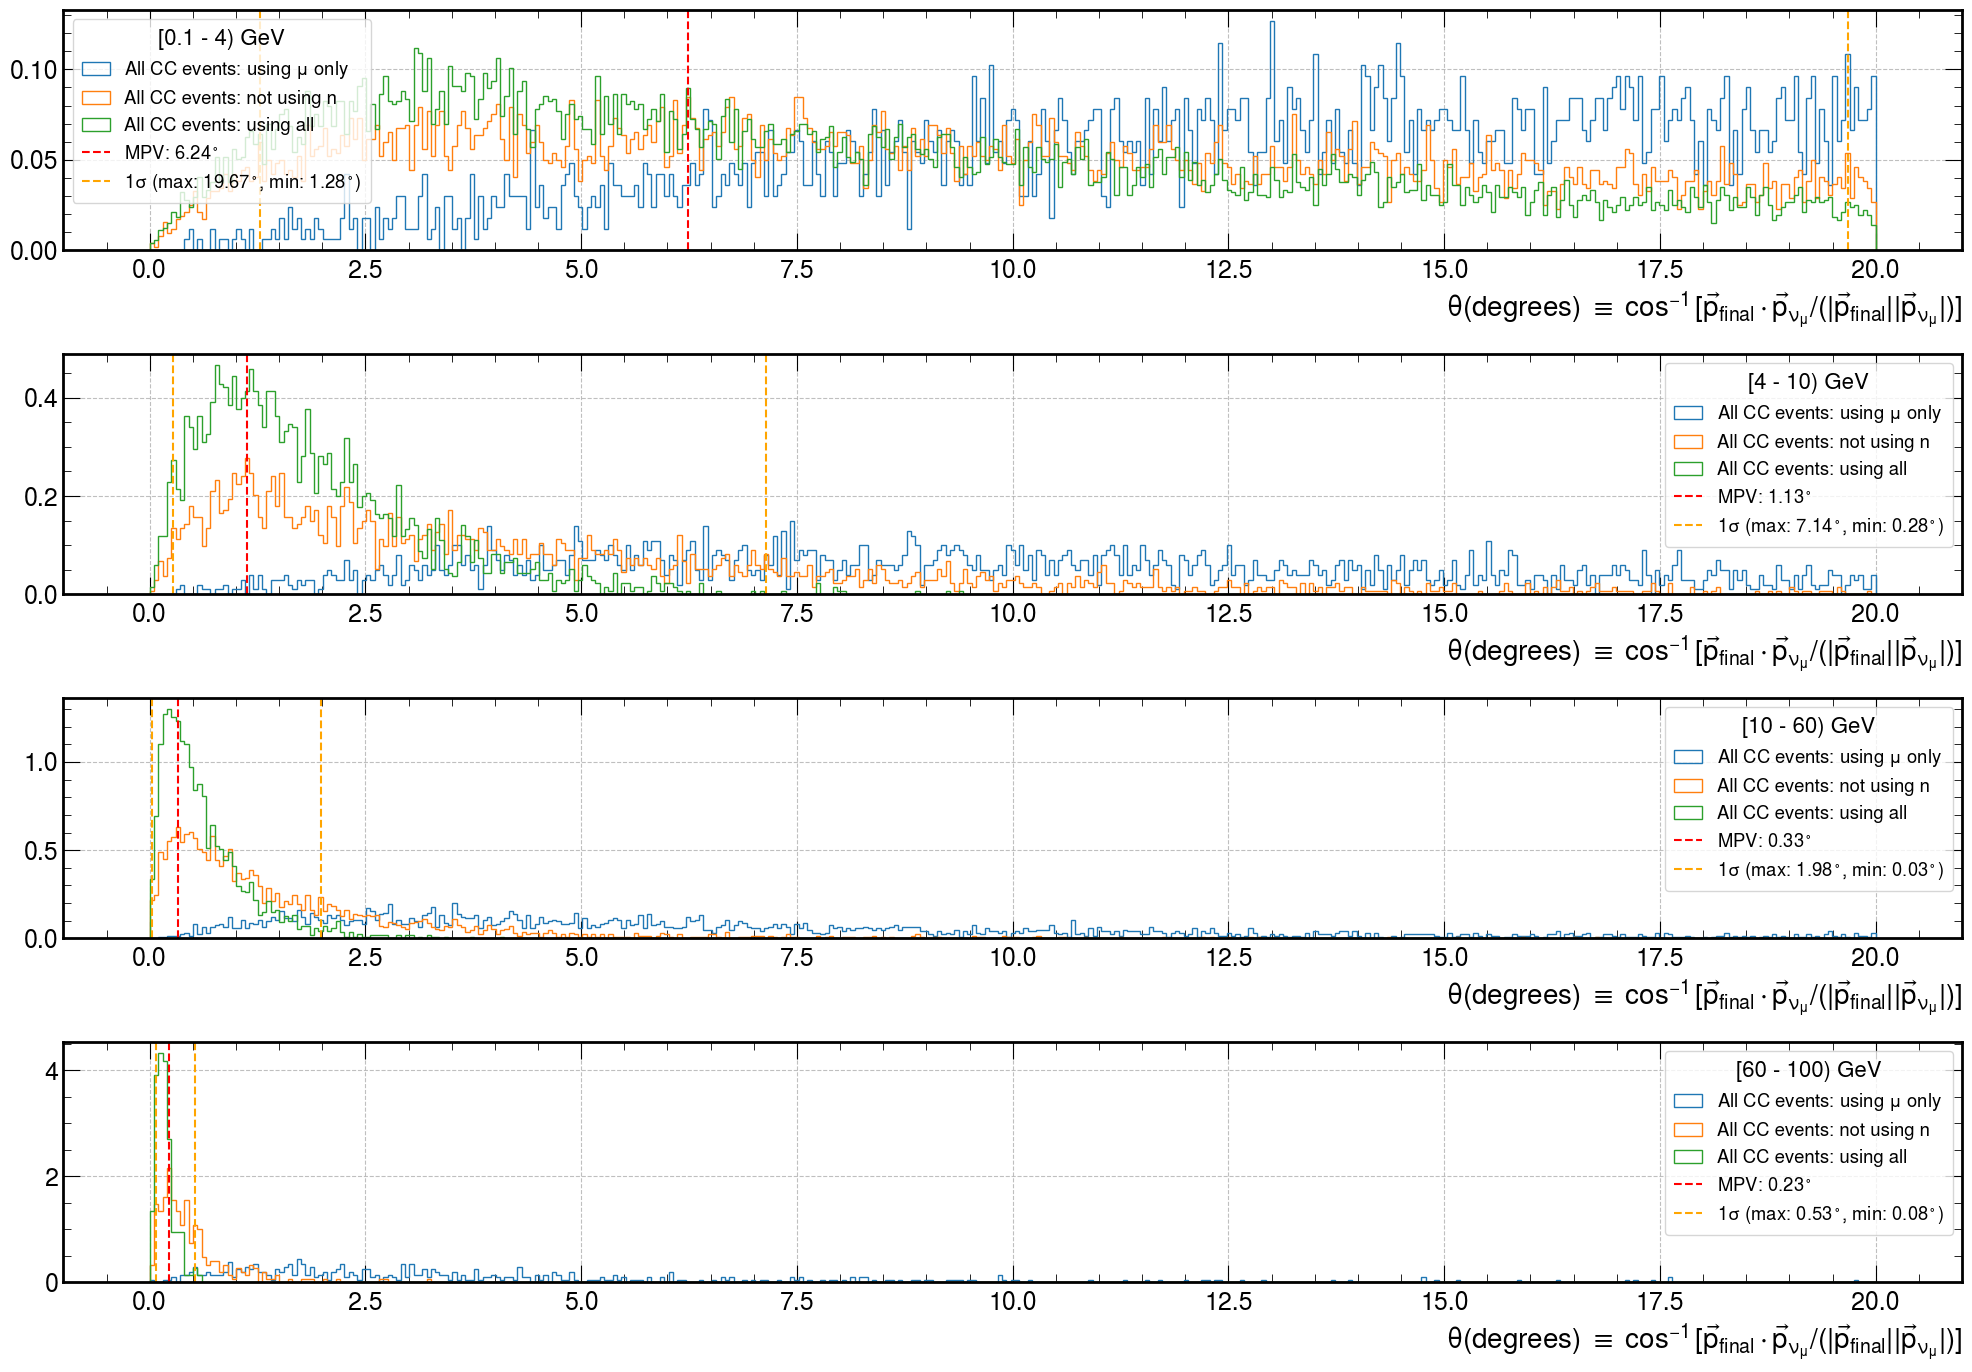

In [7]:
q3 = df.groupby(['subrun', 'event']).agg(
    pl.col('nu_dcosx_truth').first().alias('nu_dcostx_truth'),
    pl.col('nu_dcosy_truth').first().alias('nu_dcosty_truth'),
    pl.col('nu_dcosz_truth').first().alias('nu_dcostz_truth'),
    pl.col('enu_truth').first(),
    pl.col('Px_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psx_geant'),
    pl.col('Py_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psy_geant'),
    pl.col('Pz_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psz_geant'),
    pl.col('Px_geant').sum().alias('Ptx_geant'),
    pl.col('Py_geant').sum().alias('Pty_geant'),
    pl.col('Pz_geant').sum().alias('Ptz_geant'),
    pl.col('^P[a-z]_geant$'),
    pl.col('pdg_geant'),
    pl.col('pdg_geant').alias('pdg_geant_group'),
    
).with_columns(
    pl.col('pdg_geant_group').list.lengths().alias('len_select'),
    pl.col('pdg_geant').list.lengths().alias('len'),
    Pt_geant = (pl.col('Ptx_geant').pow(2) + pl.col('Pty_geant').pow(2) + pl.col('Ptz_geant').pow(2)).sqrt(),
    Ps_geant = (pl.col('Psx_geant').pow(2) + pl.col('Psy_geant').pow(2) + pl.col('Psz_geant').pow(2)).sqrt(),
)

q_all = (
    q3.select(
        pl.col('enu_truth'),
        angle_diff_s = get_angle('Ps','nu_dcost'),
        angle_diff_t = get_angle('Pt','nu_dcost'),
    )
)
Ebins=[0.1,4,10,60,100]
bins=np.linspace(0,20,400)
fig, _, _ = plot_by_energy(bins=bins, df=q,variables=['angle_diff'],labels=[r'All CC events: using $\mu$ only'], columns=1, figsize=(20,14))
fig, x, y = plot_by_energy(bins=bins, df=q_all,variables=['angle_diff_s'],labels=[r'All CC events: not using n'], fig = fig, columns=1, figsize=(20,14))
fig, x2, y2 = plot_by_energy(bins=bins, df=q_all,variables=['angle_diff_t'],labels=[r'All CC events: using all'], fig = fig, columns=1, figsize=(20,14))
axes = fig.get_axes()

def show_credibility(axes, x, y, idx=1, cred = 0.68):
    global Ebins
    intervals = create_intervals()

    hist_cred =  get1Dcred(y[idx],0.68)
    min_cred = min(hist_cred)
    max_cred = max(hist_cred)
    mode_cred = hist_cred[0]

    ax:plt.Axes
    ax = axes[idx]
    ax.axvline(x[idx][mode_cred], c='red', linestyle='--', label=fr'MPV: {x[idx][mode_cred]:0.2f}$^\circ$')
    ax.axvline(x[idx][min_cred], c='orange', linestyle='--')
    ax.axvline(x[idx][max_cred], c='orange', linestyle='--', label=rf'$1\sigma$ (max: {x[idx][max_cred]:0.2f}$^\circ$, min: {x[idx][min_cred]:0.2f}$^\circ$)')
    ax.legend(frameon=True, title=intervals[idx])

show_credibility(axes,x,y, idx = 0)
show_credibility(axes,x,y, idx =1)
show_credibility(axes,x,y, idx=2)
show_credibility(axes,x,y, idx=3)

# for ax in axes:
#     ax.set_yscale('log')
# plt.xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$')
# plt.legend()

In [35]:
b =  get1Dcred(y[1],0.68)
b[0]


29